
=== Correlations (should match SQL meaning) ===
   gender  corr_calories_intensity  corr_water_intensity  corr_meals_intensity
0  Female       0.0174117841755923    0.0938341276298427    0.0093143998836224
1    Male       0.0217643608239871    0.0891773177280658    0.0309855637313454


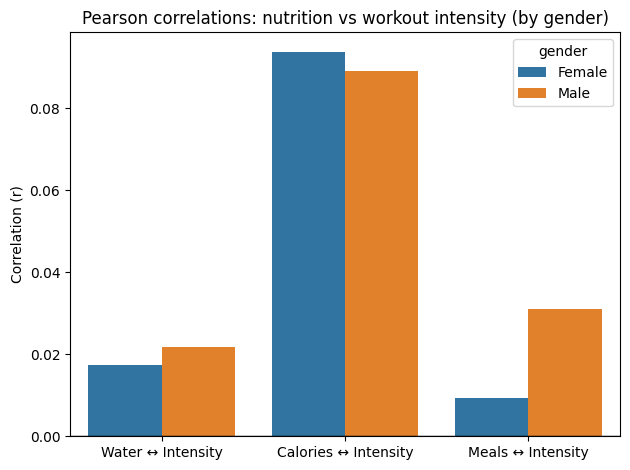

In [10]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def snake(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    return re.sub(r"_+", "_", s).strip("_")

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [snake(c) for c in df.columns]
    return df

nutrition = load_csv("nutrition_probid.csv")
proband   = load_csv("proband_probid.csv")
workout   = load_csv("workout_probid.csv")

nutrition = nutrition.rename(columns={
    "calories": "calories",
    "water_intake_liters": "water_intake_liters",
    "daily_meals_frequency": "meal_frequency"
})

nutrition_per_proband = (
    proband[["proband_id", "gender"]]
    .merge(
        nutrition[["proband_id", "calories", "water_intake_liters", "meal_frequency"]],
        on="proband_id",
        how="inner"
    )
    .groupby(["proband_id", "gender"], as_index=False)
    .agg(
        avg_calories=("calories", "mean"),
        avg_water=("water_intake_liters", "mean"),
        avg_meals=("meal_frequency", "mean"),
    )
)

# query 2
workout["intensity"] = workout["calories_burned"] / workout["session_duration_hours"].replace(0, np.nan)

intensity_per_proband = (
    workout.groupby("proband_id", as_index=False)
    .agg(avg_intensity=("intensity", "mean"))
)

# grouping correlations by gender
merged = nutrition_per_proband.merge(intensity_per_proband, on="proband_id", how="inner")

corrs = (
    merged.groupby("gender")[["avg_calories", "avg_water", "avg_meals", "avg_intensity"]]
    .apply(lambda g: pd.Series({
        "corr_calories_intensity": g["avg_calories"].corr(g["avg_intensity"]),
        "corr_water_intensity":    g["avg_water"].corr(g["avg_intensity"]),
        "corr_meals_intensity":    g["avg_meals"].corr(g["avg_intensity"]),
    }))
    .reset_index()
    .sort_values("gender")
)

print("\n=== Correlations (should match SQL meaning) ===")
pd.set_option("display.precision", 16)
print(corrs)

# plotting
corr_long = corrs.melt(
    id_vars="gender",
    var_name="metric",
    value_name="correlation"
)
label_map = {
    "corr_calories_intensity": "Water ↔ Intensity",
    "corr_water_intensity":    "Calories ↔ Intensity",
    "corr_meals_intensity":    "Meals ↔ Intensity",
}

corr_long["metric"] = corr_long["metric"].map(label_map)

sns.barplot(data=corr_long, x="metric", y="correlation", hue="gender")
plt.axhline(0, color="black", linewidth=1)
plt.title("Pearson correlations: nutrition vs workout intensity (by gender)")
plt.ylabel("Correlation (r)")
plt.xlabel("")
plt.tight_layout()
plt.show()

